# 🐱 Cat Breed Explorer: Multimodal Search with CLIP + ChromaDB 🐾
Welcome to the Cat Breed Explorer!

This is an interactive demo that showcases the power of **multimodal search** using **CLIP embeddings**, **ChromaDB**, and **LLMs**.

**In this notebook, we'll explore**:

* 🧠 ChromaDB as a Vector Store: Efficient storage and retrieval of CLIP embeddings with metadata.

* 🔍 Text-to-Image Search: Type a phrase like “a long-haired orange cat” and get images of matching breeds.

* 📸 Image-to-Text Search: Upload an image of a cat, and retrieve breed descriptions that match it.

* 📚 LLM-Powered Q&A: Ask natural language questions about breeds (e.g. “Which cat is the most affectionate?”), and get friendly, detailed answers based on retrieved context.

This is a fun and educational demo built to show how you can combine vector similarity, RAG (Retrieval-Augmented Generation), and multimodal reasoning in a real-world use case — all through the lens of adorable felines 🐱.


**Important Notes** 
* The data used in this notebook is pulled from the [CatAPI](https://developers.thecatapi.com/view-account/ylX4blBYT9FaoVd6OhvR?report=bOoHBz-8t).
If you do not have an API Key and do not wish to create one, uncomment the block
of code where you can download the json file from my [GitHub](www.github.com/Gabya06/cat_breeds).
* You **need** an API Key for [GoogleAI](https://ai.google.dev/gemini-api/docs/api-key) to be able to run this notebook.

In [ ]:
# Add src to the path for local imports
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
SRC_PATH = str(PROJECT_ROOT / "src")

sys.path.append(SRC_PATH)

In [3]:
print(SRC_PATH)

/Users/gabyagrocostea/dev/cat_breeds/src


In [5]:
# !pip install chromadb==1.0.3

In [6]:
from io import BytesIO
import os

from dotenv import load_dotenv
from google import genai
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import re
import torch
from tqdm import  tqdm

/Users/gabyagrocostea/dev/cat_breeds/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
from cat_breeds import (CatDataProcessor,
                        CatBreedQA,
                        ClipMatcher,
                        CatImageGeenerator)
from cat_breeds.utils.embedding_functions import (ClipTextEmbeddingFunction,
                                                  ClipImageEmbeddingFunction)
from cat_breeds.utils import utils

/Users/gabyagrocostea/dev/cat_breeds/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
load_dotenv()
# load Gemini API Key
api_key = os.getenv("GEMINI_API_KEY")
client = genai.Client(api_key=api_key)

## 🐱 1. Fetch Cat Breed Metadata + Images

This section pulls data from the CatAPI and download images in the `images` folder

If you dont have a CATAPI Key uncomment this and download the data from my git
and comment out the first 2 lines in the next cell

In [9]:
# !wget "https://raw.githubusercontent.com/Gabya06/cat_breeds/refs/heads/main/data/breed_data.json" breeds_data.json
# try:
#   breeds_df = pd.read_json('breed_data.json')
# except Exception as e:
#   print(f"Error downloading breed_data.json from GitHub: {e}")

In [10]:
breeds_data = CatDataProcessor.get_breeds()

# Convert the data into a DataFrame for easy processing
breeds_df = pd.DataFrame(breeds_data)

# Organize data
breeds_df = breeds_df[['id', 'name', 'origin', 'temperament', 'description',
                       'hypoallergenic','shedding_level', "life_span",
                       'affection_level' , 'health_issues', 'image']]
breeds_df['image_url'] = breeds_df['image'].apply(lambda x: x['url'] if pd.notna(x) else None)

In [11]:
breeds_df.head(2)

,id,name,origin,temperament,description,hypoallergenic,shedding_level,life_span,affection_level,health_issues,image,image_url
0,abys,Abyssinian,Egypt,"Active, Energetic, Independent, Intelligent, G...","The Abyssinian is easy to care for, and a joy ...",0,2,14 - 15,5,2,"{'id': '0XYvRd7oD', 'width': 1204, 'height': 1...",https://cdn2.thecatapi.com/images/0XYvRd7oD.jpg
1,aege,Aegean,Greece,"Affectionate, Social, Intelligent, Playful, Ac...",Native to the Greek islands known as the Cycla...,0,3,9 - 12,4,1,"{'id': 'ozEvzdVM-', 'width': 1200, 'height': 8...",https://cdn2.thecatapi.com/images/ozEvzdVM-.jpg


## 🐾 2. Download Cat Images

In [12]:
images_paths = []
# download images
for row in breeds_data:
    breed_id = row['id']
    breed_name = row['name']
    try:
        # Uncomment this if you don't have images downloaded
        # CatDataProcessor.download_images_per_breed(breed_id=breed_id,
        #                                        breed_name=breed_name, num_images=1)

        image = os.listdir(f'{PROJECT_ROOT}/images/{breed_name}')[0]
        images_paths.append(image)
    except Exception as e:
        print(e)
        images_paths.append(None)

list index out of range


In [13]:
# process data for RAG Q&A
data = CatDataProcessor.process_data_for_rag(breeds_df)

# Keep important information
data = data[['id','breed','origin','affection_level', 'shedding_level', 'health_issues' ,
             'life_span_avg', 'image_url','cat_description']]

# assign image path
data['image_path'] = images_paths
data.dropna(subset=['image_path'], inplace = True)
data.image_path = data.apply(lambda x: f'{PROJECT_ROOT}/images/{x["image_path"].split("_")[0]}/{x["image_path"]}', axis=1)

In [14]:
data.head()

,id,breed,origin,affection_level,shedding_level,health_issues,life_span_avg,image_url,cat_description,image_path
0,abys,Abyssinian,Egypt,very affectionate,shed,have few health issues,14.5,https://cdn2.thecatapi.com/images/0XYvRd7oD.jpg,"The Abyssinian is easy to care for, and a joy ...",/Users/gabyagrocostea/dev/cat_breeds/images/Ab...
1,aege,Aegean,Greece,affectionate,shed an average amount,have no health issues,10.5,https://cdn2.thecatapi.com/images/ozEvzdVM-.jpg,Native to the Greek islands known as the Cycla...,/Users/gabyagrocostea/dev/cat_breeds/images/Ae...
2,abob,American Bobtail,United States,very affectionate,shed an average amount,have no health issues,13.0,https://cdn2.thecatapi.com/images/hBXicehMA.jpg,American Bobtails are loving and incredibly in...,/Users/gabyagrocostea/dev/cat_breeds/images/Am...
3,acur,American Curl,United States,very affectionate,shed an average amount,have no health issues,14.0,https://cdn2.thecatapi.com/images/xnsqonbjW.jpg,Distinguished by truly unique ears that curl b...,/Users/gabyagrocostea/dev/cat_breeds/images/Am...
4,asho,American Shorthair,United States,very affectionate,shed an average amount,have some health issues,16.0,https://cdn2.thecatapi.com/images/JFPROfGtQ.jpg,The American Shorthair is known for its longev...,/Users/gabyagrocostea/dev/cat_breeds/images/Am...


In [16]:
sample = data.sample(3, random_state=2)

In [17]:
for ix, row in sample.iterrows():
    print(f"{row['breed']}")
    print(f"{row['cat_description']}")
    print()

Abyssinian
The Abyssinian is easy to care for, and a joy to have in your home. They’re affectionate cats and love both people and other animals. Their temperament is described as Active, Energetic, Independent, Intelligent, Gentle. They are known to be very affectionate, tend to shed and have few health issues. They typically live around 14.5 years.

Egyptian Mau
The Egyptian Mau is gentle and reserved. She loves her people and desires attention and affection from them but is wary of others. Early, continuing socialization is essential with this sensitive and sometimes shy cat, especially if you plan to show or travel with her. Otherwise, she can be easily startled by unexpected noises or events. Their temperament is described as Agile, Dependent, Gentle, Intelligent, Lively, Loyal, Playful. They are known to be very affectionate, tend to shed an average amount and have some health issues. They typically live around 19.0 years.

Singapura
The Singapura is usually cautious when it comes

## 🧠 3. Generate Embeddings for Text and Images using CLIP

In [18]:
# Generate CLIP embeddings for images and breed descriptions
embedding_documents = []
image_embeddings = []
text_embeddings = []
metadatas = []

# Loop through each row and generate embeddings for the image & cat_description
for idx, row in tqdm(data.iterrows(), total = len(data)):
    image_path = row['image_path']
    text = row['cat_description']

    image_embedding = ClipMatcher.preprocess_image(image_path=image_path) # preprocess image
    text_embedding = ClipMatcher.preprocess_text(text_list=[text]) # preprocess text

    if image_embedding is not None:
        embedding_documents.append(f"Image: {row['breed']}")  # Document description for image db
        image_embeddings.append(image_embedding)
        text_embeddings.append(text_embedding)

        # Add breed metadata
        breed_metadata = {
            "breed": row["breed"],
            "origin": row["origin"],
            "affection_level": row["affection_level"],
            "health_issues": row["health_issues"],
            "shedding_level": row["shedding_level"]
        }
        metadatas.append(breed_metadata)

100%|██████████| 66/66 [00:17<00:00,  3.88it/s]


In [19]:
# Verify lengths match across documents and embeddings
len(embedding_documents), len(image_embeddings), len(metadatas), len(text_embeddings)

(66, 66, 66, 66)

In [20]:
assert len(embedding_documents) == len(image_embeddings) == len(metadatas) == len(text_embeddings), 'Embedding sizes must equal document size'

## 💾 4. Store in ChromaDB (Embeddings + Vector Search)

Create 2 collections:
* One for cat description text storing CLIP text embeddings - so that we can query text
* One for cat images storing CLIP image embeddings - so that we can query using images

In [ ]:
# Uncomment this if already have embeddings created and stored in db folder at project root

# from chromadb import PersistentClient
# from cat_breeds.utils.embedding_functions import (
#     ClipTextEmbeddingFunction,
#     ClipImageEmbeddingFunction,
# )

# DB_PATH = PROJECT_ROOT / "db"
# # Load collection from disk
# chroma_client = PersistentClient(path=str(DB_PATH))  # "db/")
# text_collection = chroma_client.get_collection(
#     name="cat_breed_texts", embedding_function=ClipTextEmbeddingFunction()
# )
# image_collection = chroma_client.get_collection(
#     name="cat_breed_images", embedding_function=ClipImageEmbeddingFunction()
# )

/var/folders/y4/8c0n8_2x5fq9rd9gn92lqkvm0000gn/T/ipykernel_10911/1483425181.py:13: DeprecationWarning: The class ClipTextEmbeddingFunction does not implement __init__. This will be required in a future version.
  name="cat_breed_texts", embedding_function=ClipTextEmbeddingFunction()
/var/folders/y4/8c0n8_2x5fq9rd9gn92lqkvm0000gn/T/ipykernel_10911/1483425181.py:16: DeprecationWarning: The class ClipImageEmbeddingFunction does not implement __init__. This will be required in a future version.
  name="cat_breed_images", embedding_function=ClipImageEmbeddingFunction()


In [ ]:
# create text and image collections (Databases) using CLIP embeddings functions
text_embedding_fn = ClipTextEmbeddingFunction()
text_collection = utils.create_chromadb(db_name="cat_breed_texts", 
                                        embedding_function=text_embedding_fn,
                                        )

image_embedding_fn = ClipImageEmbeddingFunction()
image_collection = utils.create_chromadb(db_name="cat_breed_images", 
                                         embedding_function=image_embedding_fn,
                                         )

In [22]:
# add metadata information to facilitate filtering
metadatas = [
    {
        "breed": row["breed"],
        "origin": row["origin"],
        "affection_level": row["affection_level"],
        "health_issues": row["health_issues"],
        "shedding_level": row["shedding_level"]
    }
    for _, row in data.iterrows()
]

In [23]:
# add documents and text embeddings to text collection
text_collection.add(
    documents=[row['cat_description'] for _, row in data.iterrows()],
    ids=[str(idx) for idx in range(len(data))],
    embeddings=text_embeddings,
    metadatas=metadatas
)

In [24]:
# add documents and image embeddings to image collection
image_collection.add(
    documents=[f"Image: {row['breed']}" for _, row in data.iterrows()],
    ids=[str(idx) for idx in range(len(data))],
    embeddings=image_embeddings,
    metadatas=metadatas
)


In [22]:
# let s take a look at text db ids
text_collection.peek(10)['ids']

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [23]:
# look at embeddings shape - should match clip's 512
image_collection.peek(1)['embeddings'].shape

(1, 512)

## 😸 5. Let's explore our images and text information about cats! 👀



In [24]:
# Create cat QA
cat_qa = CatBreedQA(text_db=text_collection, image_db=image_collection,
                    data=data,client=client)

#### 🐱 RAG: Ask "What is the most affectionate cat?"

In [25]:
question_1 = "Which cat is the most affectionate?"

In [26]:
# Let's retrieve the top 2 results
results_1 = cat_qa.query(query=question_1, mode='text', n_results=2)

### Results Inspection: 👓

* `ids` corresponding to query results in our data. Notice that since we asked for 5 results back we get back 5 ids
* `documents` corresponding to cat_description in our data
* `metadata` of results: `health_issues`, `affection_level`, `shedding_level`, `breed` and `origin`
* `distances`: these are the euclidean distances between each result and the query

In [27]:
results_1

{'ids': [['24', '42']],
 'embeddings': None,
 'documents': [['The Cymric is a placid, sweet cat. They do not get too upset about anything that happens in their world. They are loving companions and adore people. They are smart and dexterous, capable of using his paws to get into cabinets or to open doors. Their temperament is described as Gentle, Loyal, Intelligent, Playful. They are known to be very affectionate, tend to shed a lot more and have some health issues. They typically live around 11.0 years.',
   'The Munchkin is an outgoing cat who enjoys being handled. She has lots of energy and is faster and more agile than she looks. The shortness of their legs does not seem to interfere with their running and leaping abilities. Their temperament is described as Agile, Easy Going, Intelligent, Playful. They are known to be very affectionate, tend to shed an average amount and have some health issues. They typically live around 12.5 years.']],
 'uris': None,
 'included': ['metadatas', '

### Generate Final Answer using LLM (GEMINI) ✔

In [28]:
# Get LLM to provide the final answer
print(cat_qa.get_answer())

Okay, I can certainly help you compare these two affectionate cat breeds!

Based on the information provided, both the Cymric and the Munchkin are known to be very affectionate! It's wonderful that you're looking for a loving companion.

Let's dive into a bit more detail about the Cymric:

*   **Cymric:** Originating from Canada, Cymrics are real sweethearts known for their gentle and loyal nature. They're also quite smart and playful! Keep in mind that Cymrics tend to shed a lot, and, like the Munchkin, they can be prone to certain health issues. Despite that, they make wonderful, loving companions.



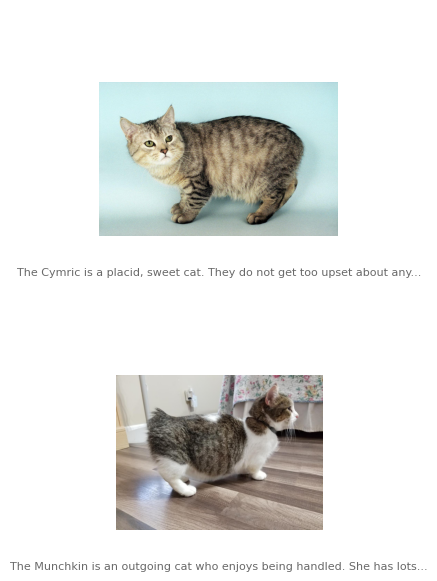

In [29]:
# Display the most affectionate cats!
cat_qa.display()

## Text to Image Query

#### 🐱 RAG: Ask "A long white haired white cat with no health issues"

In [30]:
question_2 = "A long haired white cat with no health issues"

In [31]:
results_2 = cat_qa.query(query=question_2,
                         mode='text_to_image')

In [32]:
results_2

{'ids': [['64', '11', '33']],
 'embeddings': None,
 'documents': [['Image: Turkish Van', 'Image: Birman', 'Image: Himalayan']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'origin': 'Turkey',
    'shedding_level': 'shed an average amount',
    'affection_level': 'very affectionate',
    'health_issues': 'have no health issues',
    'breed': 'Turkish Van'},
   {'affection_level': 'very affectionate',
    'breed': 'Birman',
    'origin': 'France',
    'shedding_level': 'shed an average amount',
    'health_issues': 'have no health issues'},
   {'origin': 'United States',
    'affection_level': 'very affectionate',
    'shedding_level': 'shed a lot',
    'health_issues': 'have some health issues',
    'breed': 'Himalayan'}]],
 'distances': [[1.4024943113327026, 1.4126797914505005, 1.4242392778396606]]}

### Results inspection

In the below results we can see that we do not obtain the same information in
documents, since this uses the text embedding as a look up in the image collection. 

In this way, the query compares 'long haired cat' with the document text in the image collection ('an image of a Siberian') which is anchored to those images using CLIP.

In [33]:
results_2

{'ids': [['64', '11', '33']],
 'embeddings': None,
 'documents': [['Image: Turkish Van', 'Image: Birman', 'Image: Himalayan']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'origin': 'Turkey',
    'shedding_level': 'shed an average amount',
    'affection_level': 'very affectionate',
    'health_issues': 'have no health issues',
    'breed': 'Turkish Van'},
   {'affection_level': 'very affectionate',
    'breed': 'Birman',
    'origin': 'France',
    'shedding_level': 'shed an average amount',
    'health_issues': 'have no health issues'},
   {'origin': 'United States',
    'affection_level': 'very affectionate',
    'shedding_level': 'shed a lot',
    'health_issues': 'have some health issues',
    'breed': 'Himalayan'}]],
 'distances': [[1.4024943113327026, 1.4126797914505005, 1.4242392778396606]]}

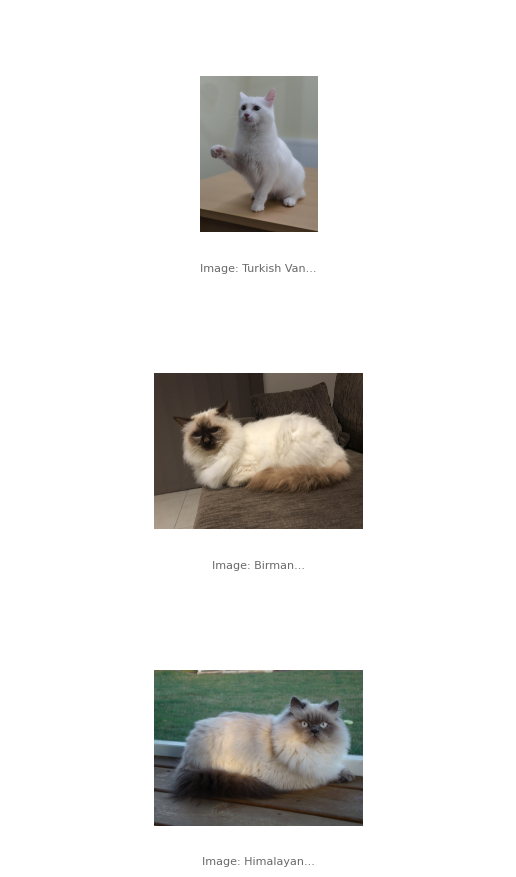

In [34]:
cat_qa.display()

### Ask Gemini for the final answer

In [35]:
print(cat_qa.get_answer())

Okay, I'd be happy to tell you about a beautiful, long-haired white cat breed that might be a great fit for you! Based on the images and information you provided, it sounds like you're interested in the **Turkish Van**.

Here's a bit about them:

*   **Origin:** These lovely cats come from Turkey.
*   **Health:** Turkish Vans are known for generally **not having major health issues**, which is always a plus!
*   **Shedding:** They **shed an average amount**, so regular brushing will help keep their coat in tip-top shape and minimize hairballs.
*   **Personality:** These cats are **very affectionate**, so expect lots of cuddles and bonding time.

Turkish Vans are truly special cats with their striking appearance and loving nature. They can make wonderful companions!



## 🐾  6. Image Matching - Cat Discovery 😼

In this section, I test out a few photos of my cats and match them with the images in the cat database.


#### What type of cat is it?

In [36]:
my_image_path = f'{PROJECT_ROOT}/images/my_pets/'

In [37]:
leo_images = [''.join(re.findall('leo_[0-9].png', x)) for x in os.listdir(my_image_path)]
leo_images = [f"{my_image_path}{x}" for x in leo_images if x]
leo_images

['/Users/gabyagrocostea/dev/cat_breeds/images/my_pets/leo_2.png',
 '/Users/gabyagrocostea/dev/cat_breeds/images/my_pets/leo_1.png']

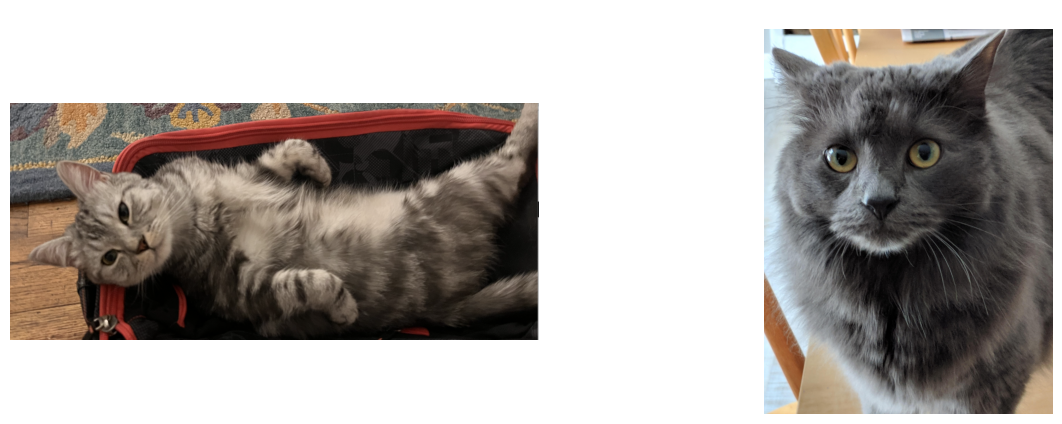

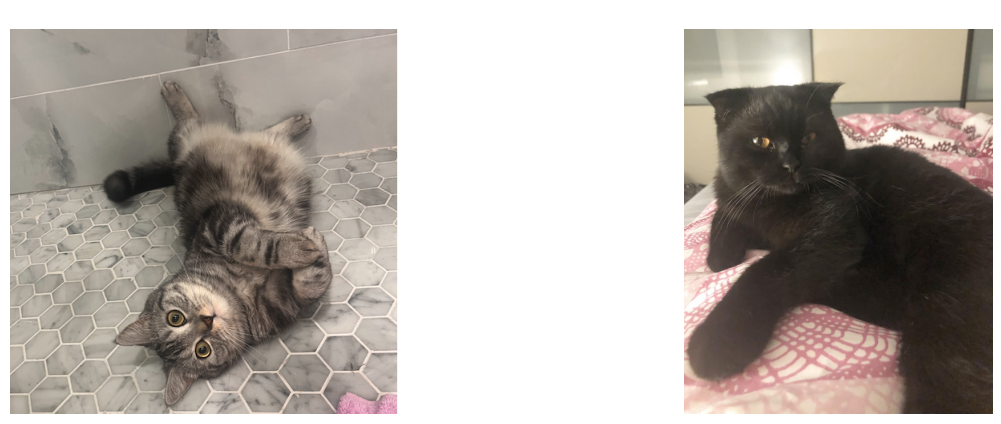

In [38]:
# Plot each image of Leo and the closest image returned by search
for leo_img in leo_images:
    leo_res = cat_qa.query(query='What kind of cat is this?', mode='image',
                         image_path=leo_img, n_results=1)
    id = int(leo_res['ids'][0][0])
    breed = leo_res['documents'][0][0]
    res_path = data.iloc[id].image_path

    fig_height = max(3, 5) 
    fig, axes = plt.subplots(
        ncols=2, nrows=1, figsize=(15, fig_height), facecolor="white"
    )

    img = Image.open(leo_img)
    res_img = Image.open(res_path)

    axes[0].imshow(img)
    axes[1].imshow(res_img)
    axes[0].set_title("Leo", fontsize=10)
    axes[1].set_title(f"{breed}", fontsize=10)
    axes[0].axis('off')
    axes[1].axis('off')

    plt.show(fig)

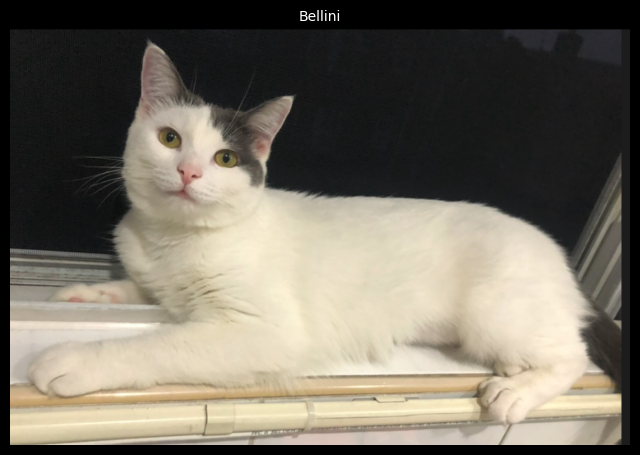

In [39]:
# Let's look at Bellini 
bellini_image = f'{PROJECT_ROOT}/images/my_pets/bellini_1.png'

fig, ax = plt.subplots(figsize=(8,6))
img = Image.open(bellini_image)

ax.imshow(img)
ax.set_title(f"Bellini", fontsize=10)
ax.axis('off')
plt.show(fig)

In [40]:
results_4 = cat_qa.query(query='What kind of cat is this? She is a fluffy white cat', mode='image',
                         image_path=bellini_image, n_results=1)

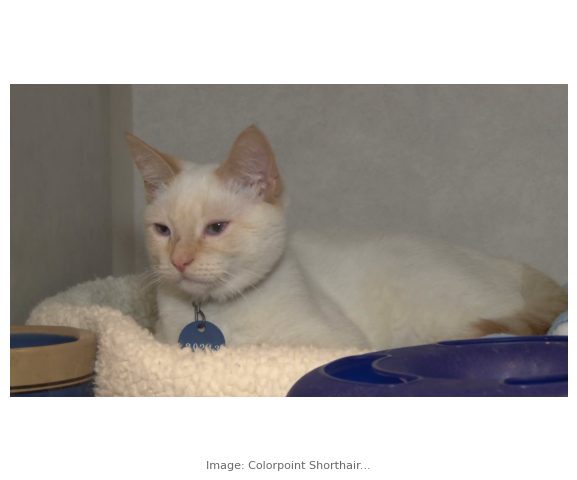

In [41]:
cat_qa.display()

In [42]:
print(cat_qa.get_answer())

Okay, that fluffy white cat looks like it could be a Colorpoint Shorthair! Here's a bit about them:

*   **Origin:** These lovely cats come from the United States.
*   **Personality:** Colorpoint Shorthairs are known to be affectionate. Expect lots of cuddles!
*   **Shedding:** They shed an average amount, so regular grooming will help keep their coat in tip-top shape and minimize hairballs.
*   **Health:** They're generally quite healthy and don't tend to have many breed-specific health issues.



## 🧩 6. Image Matching (CLIP Similarity)

Here we use cosine similarity between text embeddings and an image embeddings to 
predict the cat breed.


In [43]:
# embed Bellini's picture
bellini_embeddings = ClipMatcher.preprocess_image(bellini_image)
# embed Leo's pictures
leo_embeddings = list(map(ClipMatcher.preprocess_image, leo_images))

In [44]:
# verify embedding size
len(bellini_embeddings)

512

In [46]:
# predict Bellini's cat breed using Clip and cosine similarity
bellini_predicted_breed = ClipMatcher.predict_breed(
    breed_names=data.breed.tolist(),
    text_embeddings=text_embeddings,
    image_embedding=bellini_embeddings)

In [54]:
print(f"Bellini's predicted breed is {bellini_predicted_breed}.")

Bellini's predicted breed is ['Persian'].


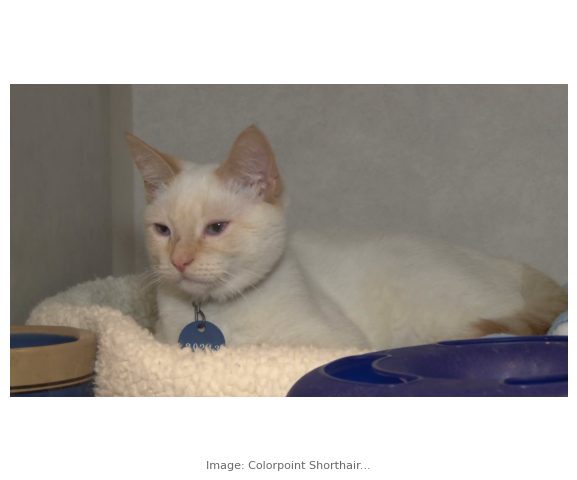

In [49]:
# I dont think this is the best picture of a Persian cat!
cat_qa.display()

### 😻 Bonus Section: Generate Similar Images using Gemini! 🥳

In [52]:
# create cat generator
cat_generator = CatImageGeenerator(client=client)

In [55]:
generated_dir = "generated_images"
generated_paths = []

# generate an image for each predicted breed
for ix, breed in enumerate(bellini_predicted_breed):
    prompt = f"Generate an image of a {breed} cat"

    image_data = cat_generator.generated_cat_images(prompt=prompt)
    breed_folder = f"{generated_dir}/{breed}"

    if not os.path.exists(breed_folder):
        os.makedirs(breed_folder)
    # save image
    if image_data:
        try:
            image = Image.open(BytesIO(image_data))
            filename = f"{breed.replace(' ', '_')}_{ix+1}.png"
            filepath = os.path.join(breed_folder, filename)
            image.save(filepath, "PNG")
            print(f" Generated and saved {filename} for {breed}")
            outpath = f'{generated_dir}/{breed}/{filename}'
            generated_paths.append(outpath)

        except Exception as e:
            print(f" Error saving image for {breed} (image {ix+1}): {e}")

    

 Generated and saved Persian_1.png for Persian


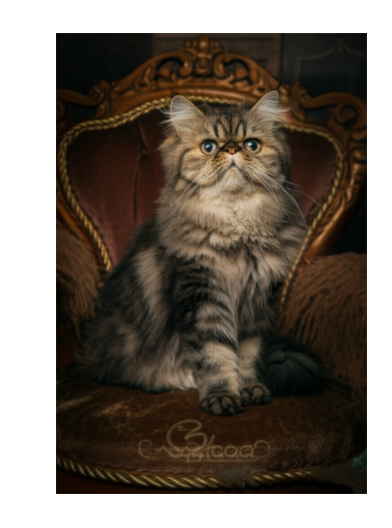

In [56]:
# plot generated image
for img_pth in generated_paths:
    try:
        img = Image.open(img_pth).convert("RGB")
        fig, ax = plt.subplots(figsize = (8,6), facecolor="white")
        ax.imshow(img)
        ax.set_title(f"{img_pth}")
        plt.show(fig)
    except Exception as e:
        print(f"could not open {img_pth}: {e}")